# CNN CIFAR-10 Dropout keep_prob

$$\begin{array}{cc}
\mbox{keep_prob_train}&\mbox{Test Accuracy}\\\hline
0.1&0.6684\\
0.2&0.71549994\\
0.3&0.7348\\
0.4&0.7382\\
0.5&0.7343\\
0.6&0.74130005\\
0.7&0.73010004\\
0.8&0.7314001\\
0.9&0.71509993\\
\end{array}$$

# keep_prob_train = 0.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.metrics import confusion_matrix

# download these four fro https://github.com/Hvass-Labs/TensorFlow-Tutorials
# we use these to download CIFAR10 dataset
import cache    # module from Hvass Labs
import dataset  # module from Hvass Labs
import download # module from Hvass Labs
import cifar10  # module from Hvass Labs

import utils

# this line should be commented out for regular python run 
%matplotlib inline  
# this line should be commented out for regular python run 


""" Hyperparameter """
data_size_train = 50000
data_size_test = 10000
batch_size = 100
lr = 1e-3
epoch = 15
keep_prob_train = 0.1


""" Data Loading """
def load_cifar10():
    # make directory if not exist
    if not os.path.isdir("data"):
        os.mkdir("data")
    if not os.path.isdir("data/CIFAR-10"):
        os.mkdir("data/CIFAR-10")

    # download and extract if not done yet
    # data is downloaded 
    # from data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    # to data_path  = "data/CIFAR-10/"
    cifar10.data_path = "data/CIFAR-10/"
    cifar10.maybe_download_and_extract()

    # load data
    x_train, y_train_cls, y_train = cifar10.load_training_data()
    x_test, y_test_cls, y_test = cifar10.load_test_data()
    class_names = cifar10.load_class_names()

    x_train = x_train.astype(np.float32)
    y_train_cls = y_train_cls.astype(np.int32)
    y_train = y_train.astype(np.float32)
    x_test = x_test.astype(np.float32)
    y_test_cls = y_test_cls.astype(np.int32)
    y_test = y_test.astype(np.float32)

    data = (x_train, y_train_cls, y_train, x_test, y_test_cls, y_test, class_names)

    return data

# x_train.shape     :  (50000, 32, 32, 3)
# x_test.shape      :  (10000, 32, 32, 3)
# y_train.shape     :  (50000, 10)
# y_test.shape      :  (10000, 10)
# y_train_cls.shape :  (50000,)
# y_test_cls.shape  :  (10000,)
data = load_cifar10()
x_train, y_train_cls, y_train, x_test, y_test_cls, y_test, class_names = data


""" Graph Construction """
tf.random.set_random_seed(337)

# placeholders
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='y')
y_cls = tf.placeholder(tf.int32, shape=(None,), name='y_cls')
keep_prob = tf.placeholder(tf.float32, shape=(), name='keep_prob')

# weights and layers #################################################################

# convolution layer 1
# input and input.shape:   x,     (None, 32, 32, 3)
# output and output.shape: conv1, (None, 16, 16, 32)
conv1_W = tf.get_variable("conv1_W", \
                          shape=(3,3,3,32), \
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
conv1 = tf.nn.conv2d(x, conv1_W, strides=(1,1,1,1), padding='SAME') # (None, 32, 32, 32)
conv1 = tf.nn.relu(conv1) # (None, 32, 32, 32)
conv1 = tf.nn.max_pool(conv1, ksize=(1,2,2,1), strides=(1,2,2,1), \
                       padding='SAME') # (None, 16, 16, 32)

# convolution layer 2
# input and input.shape:   conv1, (None, 16, 16, 32)
# output and output.shape: conv2, (None, 8, 8, 64)
conv2_W = tf.get_variable("conv2_W", \
                          shape=(3,3,32,64), \
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
conv2 = tf.nn.conv2d(conv1, conv2_W, strides=(1,1,1,1), \
                     padding='SAME') # (None, 16, 16, 64)
conv2 = tf.nn.relu(conv2) # (None, 16, 16, 64)
conv2 = tf.nn.max_pool(conv2, ksize=(1,2,2,1), strides=(1,2,2,1), \
                       padding='SAME') # (None, 8, 8, 64)

# fully connected layer
# input and input.shape:   conv2, (None, 8, 8, 64)
# output and output.shape: fc,    (None, 256) 
flatten = tf.reshape(conv2, (-1, 4096)) # (None, 4096) 
fc_W = tf.get_variable("fc_W", \
                        shape=(4096,256), \
                        initializer=tf.truncated_normal_initializer(stddev=0.1))
fc = tf.matmul(flatten, fc_W) # (None, 256) 
fc = tf.nn.relu(fc) # (None, 256)
fc = tf.nn.dropout(fc, keep_prob=keep_prob) # (None, 256)

# output layer
# input and input.shape:   fc,     (None, 256) 
# output and output.shape: logits, (None, 10) 
out_W = tf.get_variable("out_W", \
                        shape=(256, 10), \
                        initializer=tf.truncated_normal_initializer(stddev=0.1))
logits = fc @ out_W # (None, 10) 

# weights and layers #################################################################

# y_pred, and y_pred_cls 
y_pred = tf.nn.softmax(logits, name='y_pred') # probabilities
y_pred_cls = tf.argmax(logits, axis=1, output_type=tf.int32)

# cross_entropy cost function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y)
cost = tf.reduce_mean(cross_entropy)

# optimizer
train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)

# test accuracy
# you have to put test sets to compute test_accuracy
correct_bool = tf.equal(y_cls, y_pred_cls)
test_accuracy = tf.reduce_mean(tf.cast(correct_bool, tf.float32))


""" Train and Test """
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    
    # run gradient descent
    for i in range(epoch):
        if 1:
            # perform random permutaion
            idx = np.random.permutation(np.arange(data_size_train)) 
            x_batch = x_train[idx]
            y_batch = y_train[idx]
        else:
            # don't perform random permutaion
            x_batch = x_train
            y_batch = y_train
            
        cost_this_epoch = 0
        for batch_number in range(int(data_size_train/batch_size)): 
            x_b = x_batch[batch_number*batch_size:(batch_number+1)*batch_size]
            y_b = y_batch[batch_number*batch_size:(batch_number+1)*batch_size]
            feed_dict = {x: x_b, y: y_b, keep_prob: keep_prob_train}
            _, cost_now = sess.run([train_op, cost], feed_dict=feed_dict)
            cost_this_epoch += cost_now
            
        print('epoch_number    :', i)
        print('cost_this_epoch :', cost_this_epoch)
        print()

            
    # compute test accuracy and print confusion matrix 
    x_data = x_test
    y_data = y_test
    y_cls_data = y_test_cls
    y_test_cls_pred = np.zeros(shape=(data_size_test), dtype=np.int32)
    test_accuracy_list = []
    for batch_number in range(int(data_size_test/batch_size)): 
        x_b = x_data[batch_number*batch_size:(batch_number+1)*batch_size]
        y_b = y_data[batch_number*batch_size:(batch_number+1)*batch_size]
        y_cls_b = y_cls_data[batch_number*batch_size:(batch_number+1)*batch_size]
        feed_dict = {x: x_b, y: y_b, y_cls: y_cls_b, keep_prob: 1.0}
        test_accuracy_temp, y_test_cls_pred_now = sess.run([test_accuracy,y_pred_cls],
                                                           feed_dict=feed_dict)
        test_accuracy_list.append(test_accuracy_temp)
        y_test_cls_pred[batch_number*batch_size:(batch_number+1)*batch_size] = \
            y_test_cls_pred_now
        
    print('Test Accuracy: ', np.mean(np.array(test_accuracy_list)))
    
    cm = confusion_matrix(y_true=y_test_cls, y_pred=y_test_cls_pred)
    print(cm)    

Data has apparently already been downloaded and unpacked.
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch
Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta
epoch_number    : 0
cost_this_epoch : 1126.6406301259995

epoch_number    : 1
cost_this_epoch : 981.7002036571503

epoch_number    : 2
cost_this_epoch : 899.981498003006

epoch_number    : 3
cost_this_epoch : 841.0516493320465

epoch_number    : 4
cost_this_epoch : 796.299199461937

epoch_number    : 5
cost_this_epoch : 756.7098970413208

epoch_number    : 6
cost_this_epoch : 728.4919747114182

epoch_number    : 7
cost_this_epoch : 706.0903217792511

epoch_number    : 8
cost_this_epoch : 682.508617401123

epoch_

# keep_prob_train = 0.2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.metrics import confusion_matrix

import cache    # module from Hvass Labs
import dataset  # module from Hvass Labs
import download # module from Hvass Labs
import cifar10  # module from Hvass Labs

import utils

# this line should be commented out for regular python run 
%matplotlib inline  
# this line should be commented out for regular python run 


""" Hyperparameter """
data_size_train = 50000
data_size_test = 10000
batch_size = 100
lr = 1e-3
epoch = 15
keep_prob_train = 0.2


""" Data Loading """
def load_cifar10():
    # make directory if not exist
    if not os.path.isdir("data"):
        os.mkdir("data")
    if not os.path.isdir("data/CIFAR-10"):
        os.mkdir("data/CIFAR-10")

    # download and extract if not done yet
    # data is downloaded 
    # from data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    # to data_path  = "data/CIFAR-10/"
    cifar10.data_path = "data/CIFAR-10/"
    cifar10.maybe_download_and_extract()

    # load data
    x_train, y_train_cls, y_train = cifar10.load_training_data()
    x_test, y_test_cls, y_test = cifar10.load_test_data()
    class_names = cifar10.load_class_names()

    x_train = x_train.astype(np.float32)
    y_train_cls = y_train_cls.astype(np.int32)
    y_train = y_train.astype(np.float32)
    x_test = x_test.astype(np.float32)
    y_test_cls = y_test_cls.astype(np.int32)
    y_test = y_test.astype(np.float32)

    data = (x_train, y_train_cls, y_train, x_test, y_test_cls, y_test, class_names)

    return data

# x_train.shape     :  (50000, 32, 32, 3)
# x_test.shape      :  (10000, 32, 32, 3)
# y_train.shape     :  (50000, 10)
# y_test.shape      :  (10000, 10)
# y_train_cls.shape :  (50000,)
# y_test_cls.shape  :  (10000,)
data = load_cifar10()
x_train, y_train_cls, y_train, x_test, y_test_cls, y_test, class_names = data


""" Graph Construction """
tf.random.set_random_seed(337)

# placeholders
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='y')
y_cls = tf.placeholder(tf.int32, shape=(None,), name='y_cls')
keep_prob = tf.placeholder(tf.float32, shape=(), name='keep_prob')

# weights and layers #################################################################

# convolution layer 1
# input and input.shape:   x,     (None, 32, 32, 3)
# output and output.shape: conv1, (None, 16, 16, 32)
conv1_W = tf.get_variable("conv1_W", \
                          shape=(3,3,3,32), \
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
conv1 = tf.nn.conv2d(x, conv1_W, strides=(1,1,1,1), padding='SAME') # (None, 32, 32, 32)
conv1 = tf.nn.relu(conv1) # (None, 32, 32, 32)
conv1 = tf.nn.max_pool(conv1, ksize=(1,2,2,1), strides=(1,2,2,1), \
                       padding='SAME') # (None, 16, 16, 32)

# convolution layer 2
# input and input.shape:   conv1, (None, 16, 16, 32)
# output and output.shape: conv2, (None, 8, 8, 64)
conv2_W = tf.get_variable("conv2_W", \
                          shape=(3,3,32,64), \
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
conv2 = tf.nn.conv2d(conv1, conv2_W, strides=(1,1,1,1), \
                     padding='SAME') # (None, 16, 16, 64)
conv2 = tf.nn.relu(conv2) # (None, 16, 16, 64)
conv2 = tf.nn.max_pool(conv2, ksize=(1,2,2,1), strides=(1,2,2,1), \
                       padding='SAME') # (None, 8, 8, 64)

# fully connected layer
# input and input.shape:   conv2, (None, 8, 8, 64)
# output and output.shape: fc,    (None, 256) 
flatten = tf.reshape(conv2, (-1, 4096)) # (None, 4096) 
fc_W = tf.get_variable("fc_W", \
                        shape=(4096,256), \
                        initializer=tf.truncated_normal_initializer(stddev=0.1))
fc = tf.matmul(flatten, fc_W) # (None, 256) 
fc = tf.nn.relu(fc) # (None, 256)
fc = tf.nn.dropout(fc, keep_prob=keep_prob) # (None, 256)

# output layer
# input and input.shape:   fc,     (None, 256) 
# output and output.shape: logits, (None, 10) 
out_W = tf.get_variable("out_W", \
                        shape=(256, 10), \
                        initializer=tf.truncated_normal_initializer(stddev=0.1))
logits = fc @ out_W # (None, 10) 

# weights and layers #################################################################

# y_pred, and y_pred_cls 
y_pred = tf.nn.softmax(logits, name='y_pred') # probabilities
y_pred_cls = tf.argmax(logits, axis=1, output_type=tf.int32)

# cross_entropy cost function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y)
cost = tf.reduce_mean(cross_entropy)

# optimizer
train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)

# test accuracy
# you have to put test sets to compute test_accuracy
correct_bool = tf.equal(y_cls, y_pred_cls)
test_accuracy = tf.reduce_mean(tf.cast(correct_bool, tf.float32))


""" Train and Test """
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    
    # run gradient descent
    for i in range(epoch):
        if 1:
            # perform random permutaion
            idx = np.random.permutation(np.arange(data_size_train)) 
            x_batch = x_train[idx]
            y_batch = y_train[idx]
        else:
            # don't perform random permutaion
            x_batch = x_train
            y_batch = y_train
            
        cost_this_epoch = 0
        for batch_number in range(int(data_size_train/batch_size)): 
            x_b = x_batch[batch_number*batch_size:(batch_number+1)*batch_size]
            y_b = y_batch[batch_number*batch_size:(batch_number+1)*batch_size]
            feed_dict = {x: x_b, y: y_b, keep_prob: keep_prob_train}
            _, cost_now = sess.run([train_op, cost], feed_dict=feed_dict)
            cost_this_epoch += cost_now
            
        print('epoch_number    :', i)
        print('cost_this_epoch :', cost_this_epoch)
        print()

            
    # compute test accuracy and print confusion matrix 
    x_data = x_test
    y_data = y_test
    y_cls_data = y_test_cls
    y_test_cls_pred = np.zeros(shape=(data_size_test), dtype=np.int32)
    test_accuracy_list = []
    for batch_number in range(int(data_size_test/batch_size)): 
        x_b = x_data[batch_number*batch_size:(batch_number+1)*batch_size]
        y_b = y_data[batch_number*batch_size:(batch_number+1)*batch_size]
        y_cls_b = y_cls_data[batch_number*batch_size:(batch_number+1)*batch_size]
        feed_dict = {x: x_b, y: y_b, y_cls: y_cls_b, keep_prob: 1.0}
        test_accuracy_temp, y_test_cls_pred_now = sess.run([test_accuracy,y_pred_cls],
                                                           feed_dict=feed_dict)
        test_accuracy_list.append(test_accuracy_temp)
        y_test_cls_pred[batch_number*batch_size:(batch_number+1)*batch_size] = \
            y_test_cls_pred_now
        
    print('Test Accuracy: ', np.mean(np.array(test_accuracy_list)))
    
    cm = confusion_matrix(y_true=y_test_cls, y_pred=y_test_cls_pred)
    print(cm)    

Data has apparently already been downloaded and unpacked.
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch
Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta
epoch_number    : 0
cost_this_epoch : 1005.7428439855576

epoch_number    : 1
cost_this_epoch : 842.7565047740936

epoch_number    : 2
cost_this_epoch : 760.98728120327

epoch_number    : 3
cost_this_epoch : 699.8213036060333

epoch_number    : 4
cost_this_epoch : 653.4444110393524

epoch_number    : 5
cost_this_epoch : 618.9504355788231

epoch_number    : 6
cost_this_epoch : 588.4246165752411

epoch_number    : 7
cost_this_epoch : 563.3195241689682

epoch_number    : 8
cost_this_epoch : 542.7974660396576

epoch

# keep_prob_train = 0.3

Data has apparently already been downloaded and unpacked.
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch
Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta
epoch_number    : 0
cost_this_epoch : 918.9473896026611

epoch_number    : 1
cost_this_epoch : 725.478543639183

epoch_number    : 2
cost_this_epoch : 649.2502224445343

epoch_number    : 3
cost_this_epoch : 592.9789264202118

epoch_number    : 4
cost_this_epoch : 550.5807515382767

epoch_number    : 5
cost_this_epoch : 521.1219909787178

epoch_number    : 6
cost_this_epoch : 494.236294567585

epoch_number    : 7
cost_this_epoch : 466.0337928533554

epoch_number    : 8
cost_this_epoch : 445.51569896936417

epoch

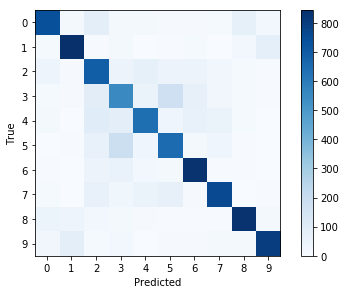

<Figure size 432x288 with 0 Axes>

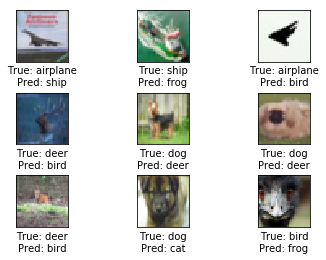

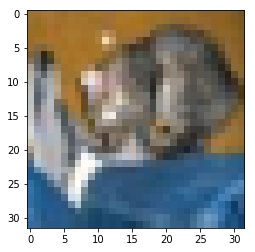

<Figure size 432x288 with 0 Axes>

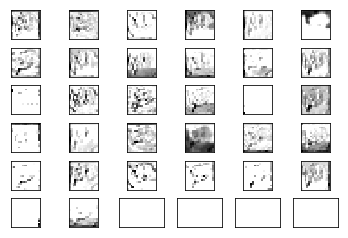

<Figure size 432x288 with 0 Axes>

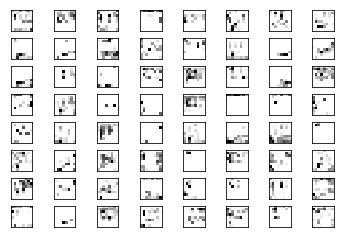

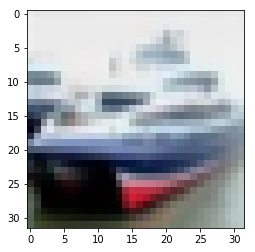

<Figure size 432x288 with 0 Axes>

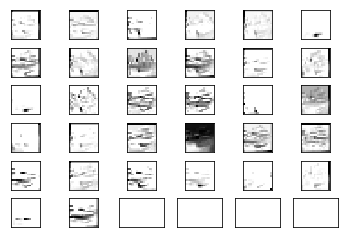

<Figure size 432x288 with 0 Axes>

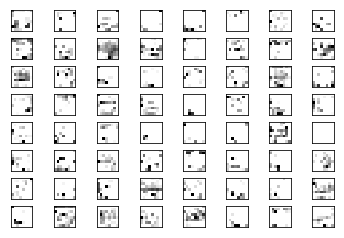

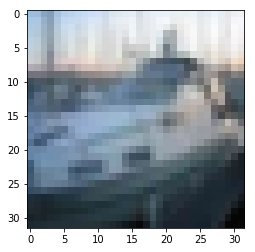

<Figure size 432x288 with 0 Axes>

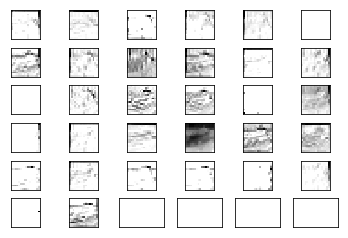

<Figure size 432x288 with 0 Axes>

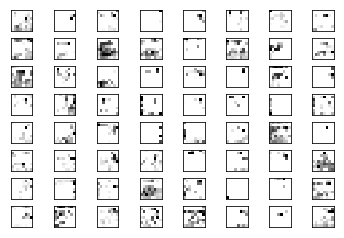

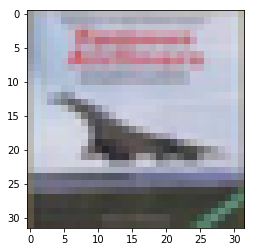

<Figure size 432x288 with 0 Axes>

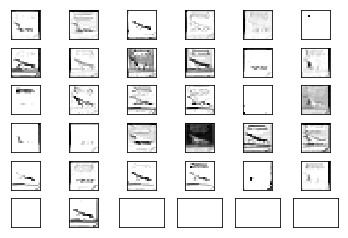

<Figure size 432x288 with 0 Axes>

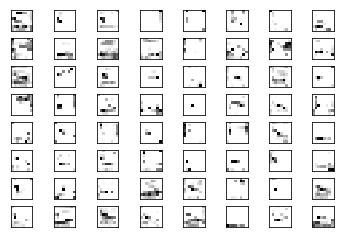

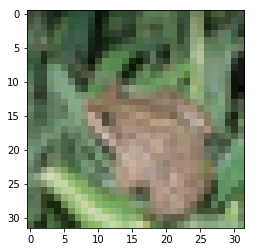

<Figure size 432x288 with 0 Axes>

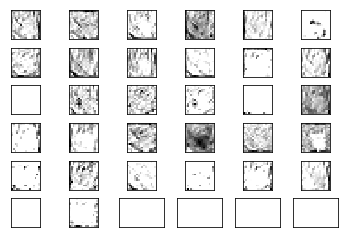

<Figure size 432x288 with 0 Axes>

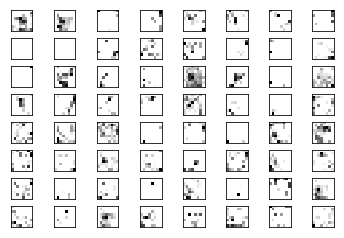

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.metrics import confusion_matrix

import cache    # module from Hvass Labs
import dataset  # module from Hvass Labs
import download # module from Hvass Labs
import cifar10  # module from Hvass Labs

import utils

# this line should be commented out for regular python run 
%matplotlib inline  
# this line should be commented out for regular python run 


""" Hyperparameter """
data_size_train = 50000
data_size_test = 10000
batch_size = 100
lr = 1e-3
epoch = 15
keep_prob_train = 0.3


""" Data Loading """
def load_cifar10():
    # make directory if not exist
    if not os.path.isdir("data"):
        os.mkdir("data")
    if not os.path.isdir("data/CIFAR-10"):
        os.mkdir("data/CIFAR-10")

    # download and extract if not done yet
    # data is downloaded 
    # from data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    # to data_path  = "data/CIFAR-10/"
    cifar10.data_path = "data/CIFAR-10/"
    cifar10.maybe_download_and_extract()

    # load data
    x_train, y_train_cls, y_train = cifar10.load_training_data()
    x_test, y_test_cls, y_test = cifar10.load_test_data()
    class_names = cifar10.load_class_names()

    x_train = x_train.astype(np.float32)
    y_train_cls = y_train_cls.astype(np.int32)
    y_train = y_train.astype(np.float32)
    x_test = x_test.astype(np.float32)
    y_test_cls = y_test_cls.astype(np.int32)
    y_test = y_test.astype(np.float32)

    data = (x_train, y_train_cls, y_train, x_test, y_test_cls, y_test, class_names)

    return data

# x_train.shape     :  (50000, 32, 32, 3)
# x_test.shape      :  (10000, 32, 32, 3)
# y_train.shape     :  (50000, 10)
# y_test.shape      :  (10000, 10)
# y_train_cls.shape :  (50000,)
# y_test_cls.shape  :  (10000,)
data = load_cifar10()
x_train, y_train_cls, y_train, x_test, y_test_cls, y_test, class_names = data


""" Graph Construction """
tf.random.set_random_seed(337)

# placeholders
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='y')
y_cls = tf.placeholder(tf.int32, shape=(None,), name='y_cls')
keep_prob = tf.placeholder(tf.float32, shape=(), name='keep_prob')

# weights and layers #################################################################

# convolution layer 1
# input and input.shape:   x,     (None, 32, 32, 3)
# output and output.shape: conv1, (None, 16, 16, 32)
conv1_W = tf.get_variable("conv1_W", \
                          shape=(3,3,3,32), \
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
conv1 = tf.nn.conv2d(x, conv1_W, strides=(1,1,1,1), padding='SAME') # (None, 32, 32, 32)
conv1 = tf.nn.relu(conv1) # (None, 32, 32, 32)
conv1 = tf.nn.max_pool(conv1, ksize=(1,2,2,1), strides=(1,2,2,1), \
                       padding='SAME') # (None, 16, 16, 32)

# convolution layer 2
# input and input.shape:   conv1, (None, 16, 16, 32)
# output and output.shape: conv2, (None, 8, 8, 64)
conv2_W = tf.get_variable("conv2_W", \
                          shape=(3,3,32,64), \
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
conv2 = tf.nn.conv2d(conv1, conv2_W, strides=(1,1,1,1), \
                     padding='SAME') # (None, 16, 16, 64)
conv2 = tf.nn.relu(conv2) # (None, 16, 16, 64)
conv2 = tf.nn.max_pool(conv2, ksize=(1,2,2,1), strides=(1,2,2,1), \
                       padding='SAME') # (None, 8, 8, 64)

# fully connected layer
# input and input.shape:   conv2, (None, 8, 8, 64)
# output and output.shape: fc,    (None, 256) 
flatten = tf.reshape(conv2, (-1, 4096)) # (None, 4096) 
fc_W = tf.get_variable("fc_W", \
                        shape=(4096,256), \
                        initializer=tf.truncated_normal_initializer(stddev=0.1))
fc = tf.matmul(flatten, fc_W) # (None, 256) 
fc = tf.nn.relu(fc) # (None, 256)
fc = tf.nn.dropout(fc, keep_prob=keep_prob) # (None, 256)

# output layer
# input and input.shape:   fc,     (None, 256) 
# output and output.shape: logits, (None, 10) 
out_W = tf.get_variable("out_W", \
                        shape=(256, 10), \
                        initializer=tf.truncated_normal_initializer(stddev=0.1))
logits = fc @ out_W # (None, 10) 

# weights and layers #################################################################

# y_pred, and y_pred_cls 
y_pred = tf.nn.softmax(logits, name='y_pred') # probabilities
y_pred_cls = tf.argmax(logits, axis=1, output_type=tf.int32)

# cross_entropy cost function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y)
cost = tf.reduce_mean(cross_entropy)

# optimizer
train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)

# test accuracy
# you have to put test sets to compute test_accuracy
correct_bool = tf.equal(y_cls, y_pred_cls)
test_accuracy = tf.reduce_mean(tf.cast(correct_bool, tf.float32))


""" Train and Test """
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    
    # run gradient descent
    for i in range(epoch):
        if 1:
            # perform random permutaion
            idx = np.random.permutation(np.arange(data_size_train)) 
            x_batch = x_train[idx]
            y_batch = y_train[idx]
        else:
            # don't perform random permutaion
            x_batch = x_train
            y_batch = y_train
            
        cost_this_epoch = 0
        for batch_number in range(int(data_size_train/batch_size)): 
            x_b = x_batch[batch_number*batch_size:(batch_number+1)*batch_size]
            y_b = y_batch[batch_number*batch_size:(batch_number+1)*batch_size]
            feed_dict = {x: x_b, y: y_b, keep_prob: keep_prob_train}
            _, cost_now = sess.run([train_op, cost], feed_dict=feed_dict)
            cost_this_epoch += cost_now
            
        print('epoch_number    :', i)
        print('cost_this_epoch :', cost_this_epoch)
        print()

            
    # compute test accuracy and print confusion matrix 
    x_data = x_test
    y_data = y_test
    y_cls_data = y_test_cls
    y_test_cls_pred = np.zeros(shape=(data_size_test), dtype=np.int32)
    test_accuracy_list = []
    for batch_number in range(int(data_size_test/batch_size)): 
        x_b = x_data[batch_number*batch_size:(batch_number+1)*batch_size]
        y_b = y_data[batch_number*batch_size:(batch_number+1)*batch_size]
        y_cls_b = y_cls_data[batch_number*batch_size:(batch_number+1)*batch_size]
        feed_dict = {x: x_b, y: y_b, y_cls: y_cls_b, keep_prob: 1.0}
        test_accuracy_temp, y_test_cls_pred_now = sess.run([test_accuracy,y_pred_cls],
                                                           feed_dict=feed_dict)
        test_accuracy_list.append(test_accuracy_temp)
        y_test_cls_pred[batch_number*batch_size:(batch_number+1)*batch_size] = \
            y_test_cls_pred_now
        
    print('Test Accuracy: ', np.mean(np.array(test_accuracy_list)))
    
    cm = confusion_matrix(y_true=y_test_cls, y_pred=y_test_cls_pred)
    print(cm)    

# keep_prob_train = 0.4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.metrics import confusion_matrix

import cache    # module from Hvass Labs
import dataset  # module from Hvass Labs
import download # module from Hvass Labs
import cifar10  # module from Hvass Labs

import utils

# this line should be commented out for regular python run 
%matplotlib inline  
# this line should be commented out for regular python run 


""" Hyperparameter """
data_size_train = 50000
data_size_test = 10000
batch_size = 100
lr = 1e-3
epoch = 15
keep_prob_train = 0.4


""" Data Loading """
def load_cifar10():
    # make directory if not exist
    if not os.path.isdir("data"):
        os.mkdir("data")
    if not os.path.isdir("data/CIFAR-10"):
        os.mkdir("data/CIFAR-10")

    # download and extract if not done yet
    # data is downloaded 
    # from data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    # to data_path  = "data/CIFAR-10/"
    cifar10.data_path = "data/CIFAR-10/"
    cifar10.maybe_download_and_extract()

    # load data
    x_train, y_train_cls, y_train = cifar10.load_training_data()
    x_test, y_test_cls, y_test = cifar10.load_test_data()
    class_names = cifar10.load_class_names()

    x_train = x_train.astype(np.float32)
    y_train_cls = y_train_cls.astype(np.int32)
    y_train = y_train.astype(np.float32)
    x_test = x_test.astype(np.float32)
    y_test_cls = y_test_cls.astype(np.int32)
    y_test = y_test.astype(np.float32)

    data = (x_train, y_train_cls, y_train, x_test, y_test_cls, y_test, class_names)

    return data

# x_train.shape     :  (50000, 32, 32, 3)
# x_test.shape      :  (10000, 32, 32, 3)
# y_train.shape     :  (50000, 10)
# y_test.shape      :  (10000, 10)
# y_train_cls.shape :  (50000,)
# y_test_cls.shape  :  (10000,)
data = load_cifar10()
x_train, y_train_cls, y_train, x_test, y_test_cls, y_test, class_names = data


""" Graph Construction """
tf.random.set_random_seed(337)

# placeholders
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='y')
y_cls = tf.placeholder(tf.int32, shape=(None,), name='y_cls')
keep_prob = tf.placeholder(tf.float32, shape=(), name='keep_prob')

# weights and layers #################################################################

# convolution layer 1
# input and input.shape:   x,     (None, 32, 32, 3)
# output and output.shape: conv1, (None, 16, 16, 32)
conv1_W = tf.get_variable("conv1_W", \
                          shape=(3,3,3,32), \
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
conv1 = tf.nn.conv2d(x, conv1_W, strides=(1,1,1,1), padding='SAME') # (None, 32, 32, 32)
conv1 = tf.nn.relu(conv1) # (None, 32, 32, 32)
conv1 = tf.nn.max_pool(conv1, ksize=(1,2,2,1), strides=(1,2,2,1), \
                       padding='SAME') # (None, 16, 16, 32)

# convolution layer 2
# input and input.shape:   conv1, (None, 16, 16, 32)
# output and output.shape: conv2, (None, 8, 8, 64)
conv2_W = tf.get_variable("conv2_W", \
                          shape=(3,3,32,64), \
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
conv2 = tf.nn.conv2d(conv1, conv2_W, strides=(1,1,1,1), \
                     padding='SAME') # (None, 16, 16, 64)
conv2 = tf.nn.relu(conv2) # (None, 16, 16, 64)
conv2 = tf.nn.max_pool(conv2, ksize=(1,2,2,1), strides=(1,2,2,1), \
                       padding='SAME') # (None, 8, 8, 64)

# fully connected layer
# input and input.shape:   conv2, (None, 8, 8, 64)
# output and output.shape: fc,    (None, 256) 
flatten = tf.reshape(conv2, (-1, 4096)) # (None, 4096) 
fc_W = tf.get_variable("fc_W", \
                        shape=(4096,256), \
                        initializer=tf.truncated_normal_initializer(stddev=0.1))
fc = tf.matmul(flatten, fc_W) # (None, 256) 
fc = tf.nn.relu(fc) # (None, 256)
fc = tf.nn.dropout(fc, keep_prob=keep_prob) # (None, 256)

# output layer
# input and input.shape:   fc,     (None, 256) 
# output and output.shape: logits, (None, 10) 
out_W = tf.get_variable("out_W", \
                        shape=(256, 10), \
                        initializer=tf.truncated_normal_initializer(stddev=0.1))
logits = fc @ out_W # (None, 10) 

# weights and layers #################################################################

# y_pred, and y_pred_cls 
y_pred = tf.nn.softmax(logits, name='y_pred') # probabilities
y_pred_cls = tf.argmax(logits, axis=1, output_type=tf.int32)

# cross_entropy cost function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y)
cost = tf.reduce_mean(cross_entropy)

# optimizer
train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)

# test accuracy
# you have to put test sets to compute test_accuracy
correct_bool = tf.equal(y_cls, y_pred_cls)
test_accuracy = tf.reduce_mean(tf.cast(correct_bool, tf.float32))


""" Train and Test """
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    
    # run gradient descent
    for i in range(epoch):
        if 1:
            # perform random permutaion
            idx = np.random.permutation(np.arange(data_size_train)) 
            x_batch = x_train[idx]
            y_batch = y_train[idx]
        else:
            # don't perform random permutaion
            x_batch = x_train
            y_batch = y_train
            
        cost_this_epoch = 0
        for batch_number in range(int(data_size_train/batch_size)): 
            x_b = x_batch[batch_number*batch_size:(batch_number+1)*batch_size]
            y_b = y_batch[batch_number*batch_size:(batch_number+1)*batch_size]
            feed_dict = {x: x_b, y: y_b, keep_prob: keep_prob_train}
            _, cost_now = sess.run([train_op, cost], feed_dict=feed_dict)
            cost_this_epoch += cost_now
            
        print('epoch_number    :', i)
        print('cost_this_epoch :', cost_this_epoch)
        print()

            
    # compute test accuracy and print confusion matrix 
    x_data = x_test
    y_data = y_test
    y_cls_data = y_test_cls
    y_test_cls_pred = np.zeros(shape=(data_size_test), dtype=np.int32)
    test_accuracy_list = []
    for batch_number in range(int(data_size_test/batch_size)): 
        x_b = x_data[batch_number*batch_size:(batch_number+1)*batch_size]
        y_b = y_data[batch_number*batch_size:(batch_number+1)*batch_size]
        y_cls_b = y_cls_data[batch_number*batch_size:(batch_number+1)*batch_size]
        feed_dict = {x: x_b, y: y_b, y_cls: y_cls_b, keep_prob: 1.0}
        test_accuracy_temp, y_test_cls_pred_now = sess.run([test_accuracy,y_pred_cls],
                                                           feed_dict=feed_dict)
        test_accuracy_list.append(test_accuracy_temp)
        y_test_cls_pred[batch_number*batch_size:(batch_number+1)*batch_size] = \
            y_test_cls_pred_now
        
    print('Test Accuracy: ', np.mean(np.array(test_accuracy_list)))
    
    cm = confusion_matrix(y_true=y_test_cls, y_pred=y_test_cls_pred)
    print(cm)    

Data has apparently already been downloaded and unpacked.
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch
Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta
epoch_number    : 0
cost_this_epoch : 871.7154358625412

epoch_number    : 1
cost_this_epoch : 684.9053485393524

epoch_number    : 2
cost_this_epoch : 602.1562440991402

epoch_number    : 3
cost_this_epoch : 551.2586188316345

epoch_number    : 4
cost_this_epoch : 511.0527101159096

epoch_number    : 5
cost_this_epoch : 478.96007388830185

epoch_number    : 6
cost_this_epoch : 449.25347232818604

epoch_number    : 7
cost_this_epoch : 427.53531259298325

epoch_number    : 8
cost_this_epoch : 403.8731724023819

e

# keep_prob_train = 0.5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.metrics import confusion_matrix

import cache    # module from Hvass Labs
import dataset  # module from Hvass Labs
import download # module from Hvass Labs
import cifar10  # module from Hvass Labs

import utils

# this line should be commented out for regular python run 
%matplotlib inline  
# this line should be commented out for regular python run 


""" Hyperparameter """
data_size_train = 50000
data_size_test = 10000
batch_size = 100
lr = 1e-3
epoch = 15
keep_prob_train = 0.5


""" Data Loading """
def load_cifar10():
    # make directory if not exist
    if not os.path.isdir("data"):
        os.mkdir("data")
    if not os.path.isdir("data/CIFAR-10"):
        os.mkdir("data/CIFAR-10")

    # download and extract if not done yet
    # data is downloaded 
    # from data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    # to data_path  = "data/CIFAR-10/"
    cifar10.data_path = "data/CIFAR-10/"
    cifar10.maybe_download_and_extract()

    # load data
    x_train, y_train_cls, y_train = cifar10.load_training_data()
    x_test, y_test_cls, y_test = cifar10.load_test_data()
    class_names = cifar10.load_class_names()

    x_train = x_train.astype(np.float32)
    y_train_cls = y_train_cls.astype(np.int32)
    y_train = y_train.astype(np.float32)
    x_test = x_test.astype(np.float32)
    y_test_cls = y_test_cls.astype(np.int32)
    y_test = y_test.astype(np.float32)

    data = (x_train, y_train_cls, y_train, x_test, y_test_cls, y_test, class_names)

    return data

# x_train.shape     :  (50000, 32, 32, 3)
# x_test.shape      :  (10000, 32, 32, 3)
# y_train.shape     :  (50000, 10)
# y_test.shape      :  (10000, 10)
# y_train_cls.shape :  (50000,)
# y_test_cls.shape  :  (10000,)
data = load_cifar10()
x_train, y_train_cls, y_train, x_test, y_test_cls, y_test, class_names = data


""" Graph Construction """
tf.random.set_random_seed(337)

# placeholders
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='y')
y_cls = tf.placeholder(tf.int32, shape=(None,), name='y_cls')
keep_prob = tf.placeholder(tf.float32, shape=(), name='keep_prob')

# weights and layers #################################################################

# convolution layer 1
# input and input.shape:   x,     (None, 32, 32, 3)
# output and output.shape: conv1, (None, 16, 16, 32)
conv1_W = tf.get_variable("conv1_W", \
                          shape=(3,3,3,32), \
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
conv1 = tf.nn.conv2d(x, conv1_W, strides=(1,1,1,1), padding='SAME') # (None, 32, 32, 32)
conv1 = tf.nn.relu(conv1) # (None, 32, 32, 32)
conv1 = tf.nn.max_pool(conv1, ksize=(1,2,2,1), strides=(1,2,2,1), \
                       padding='SAME') # (None, 16, 16, 32)

# convolution layer 2
# input and input.shape:   conv1, (None, 16, 16, 32)
# output and output.shape: conv2, (None, 8, 8, 64)
conv2_W = tf.get_variable("conv2_W", \
                          shape=(3,3,32,64), \
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
conv2 = tf.nn.conv2d(conv1, conv2_W, strides=(1,1,1,1), \
                     padding='SAME') # (None, 16, 16, 64)
conv2 = tf.nn.relu(conv2) # (None, 16, 16, 64)
conv2 = tf.nn.max_pool(conv2, ksize=(1,2,2,1), strides=(1,2,2,1), \
                       padding='SAME') # (None, 8, 8, 64)

# fully connected layer
# input and input.shape:   conv2, (None, 8, 8, 64)
# output and output.shape: fc,    (None, 256) 
flatten = tf.reshape(conv2, (-1, 4096)) # (None, 4096) 
fc_W = tf.get_variable("fc_W", \
                        shape=(4096,256), \
                        initializer=tf.truncated_normal_initializer(stddev=0.1))
fc = tf.matmul(flatten, fc_W) # (None, 256) 
fc = tf.nn.relu(fc) # (None, 256)
fc = tf.nn.dropout(fc, keep_prob=keep_prob) # (None, 256)

# output layer
# input and input.shape:   fc,     (None, 256) 
# output and output.shape: logits, (None, 10) 
out_W = tf.get_variable("out_W", \
                        shape=(256, 10), \
                        initializer=tf.truncated_normal_initializer(stddev=0.1))
logits = fc @ out_W # (None, 10) 

# weights and layers #################################################################

# y_pred, and y_pred_cls 
y_pred = tf.nn.softmax(logits, name='y_pred') # probabilities
y_pred_cls = tf.argmax(logits, axis=1, output_type=tf.int32)

# cross_entropy cost function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y)
cost = tf.reduce_mean(cross_entropy)

# optimizer
train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)

# test accuracy
# you have to put test sets to compute test_accuracy
correct_bool = tf.equal(y_cls, y_pred_cls)
test_accuracy = tf.reduce_mean(tf.cast(correct_bool, tf.float32))


""" Train and Test """
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    
    # run gradient descent
    for i in range(epoch):
        if 1:
            # perform random permutaion
            idx = np.random.permutation(np.arange(data_size_train)) 
            x_batch = x_train[idx]
            y_batch = y_train[idx]
        else:
            # don't perform random permutaion
            x_batch = x_train
            y_batch = y_train
            
        cost_this_epoch = 0
        for batch_number in range(int(data_size_train/batch_size)): 
            x_b = x_batch[batch_number*batch_size:(batch_number+1)*batch_size]
            y_b = y_batch[batch_number*batch_size:(batch_number+1)*batch_size]
            feed_dict = {x: x_b, y: y_b, keep_prob: keep_prob_train}
            _, cost_now = sess.run([train_op, cost], feed_dict=feed_dict)
            cost_this_epoch += cost_now
            
        print('epoch_number    :', i)
        print('cost_this_epoch :', cost_this_epoch)
        print()

            
    # compute test accuracy and print confusion matrix 
    x_data = x_test
    y_data = y_test
    y_cls_data = y_test_cls
    y_test_cls_pred = np.zeros(shape=(data_size_test), dtype=np.int32)
    test_accuracy_list = []
    for batch_number in range(int(data_size_test/batch_size)): 
        x_b = x_data[batch_number*batch_size:(batch_number+1)*batch_size]
        y_b = y_data[batch_number*batch_size:(batch_number+1)*batch_size]
        y_cls_b = y_cls_data[batch_number*batch_size:(batch_number+1)*batch_size]
        feed_dict = {x: x_b, y: y_b, y_cls: y_cls_b, keep_prob: 1.0}
        test_accuracy_temp, y_test_cls_pred_now = sess.run([test_accuracy,y_pred_cls],
                                                           feed_dict=feed_dict)
        test_accuracy_list.append(test_accuracy_temp)
        y_test_cls_pred[batch_number*batch_size:(batch_number+1)*batch_size] = \
            y_test_cls_pred_now
        
    print('Test Accuracy: ', np.mean(np.array(test_accuracy_list)))
    
    cm = confusion_matrix(y_true=y_test_cls, y_pred=y_test_cls_pred)
    print(cm)    

Data has apparently already been downloaded and unpacked.
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch
Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta
epoch_number    : 0
cost_this_epoch : 837.5917329788208

epoch_number    : 1
cost_this_epoch : 641.9156765937805

epoch_number    : 2
cost_this_epoch : 563.946054816246

epoch_number    : 3
cost_this_epoch : 508.94448840618134

epoch_number    : 4
cost_this_epoch : 466.3998314142227

epoch_number    : 5
cost_this_epoch : 433.32089471817017

epoch_number    : 6
cost_this_epoch : 403.4140433073044

epoch_number    : 7
cost_this_epoch : 375.13320872187614

epoch_number    : 8
cost_this_epoch : 350.25237342715263

e

# keep_prob_train = 0.6

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.metrics import confusion_matrix

import cache    # module from Hvass Labs
import dataset  # module from Hvass Labs
import download # module from Hvass Labs
import cifar10  # module from Hvass Labs

import utils

# this line should be commented out for regular python run 
%matplotlib inline  
# this line should be commented out for regular python run 


""" Hyperparameter """
data_size_train = 50000
data_size_test = 10000
batch_size = 100
lr = 1e-3
epoch = 15
keep_prob_train = 0.6


""" Data Loading """
def load_cifar10():
    # make directory if not exist
    if not os.path.isdir("data"):
        os.mkdir("data")
    if not os.path.isdir("data/CIFAR-10"):
        os.mkdir("data/CIFAR-10")

    # download and extract if not done yet
    # data is downloaded 
    # from data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    # to data_path  = "data/CIFAR-10/"
    cifar10.data_path = "data/CIFAR-10/"
    cifar10.maybe_download_and_extract()

    # load data
    x_train, y_train_cls, y_train = cifar10.load_training_data()
    x_test, y_test_cls, y_test = cifar10.load_test_data()
    class_names = cifar10.load_class_names()

    x_train = x_train.astype(np.float32)
    y_train_cls = y_train_cls.astype(np.int32)
    y_train = y_train.astype(np.float32)
    x_test = x_test.astype(np.float32)
    y_test_cls = y_test_cls.astype(np.int32)
    y_test = y_test.astype(np.float32)

    data = (x_train, y_train_cls, y_train, x_test, y_test_cls, y_test, class_names)

    return data

# x_train.shape     :  (50000, 32, 32, 3)
# x_test.shape      :  (10000, 32, 32, 3)
# y_train.shape     :  (50000, 10)
# y_test.shape      :  (10000, 10)
# y_train_cls.shape :  (50000,)
# y_test_cls.shape  :  (10000,)
data = load_cifar10()
x_train, y_train_cls, y_train, x_test, y_test_cls, y_test, class_names = data


""" Graph Construction """
tf.random.set_random_seed(337)

# placeholders
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='y')
y_cls = tf.placeholder(tf.int32, shape=(None,), name='y_cls')
keep_prob = tf.placeholder(tf.float32, shape=(), name='keep_prob')

# weights and layers #################################################################

# convolution layer 1
# input and input.shape:   x,     (None, 32, 32, 3)
# output and output.shape: conv1, (None, 16, 16, 32)
conv1_W = tf.get_variable("conv1_W", \
                          shape=(3,3,3,32), \
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
conv1 = tf.nn.conv2d(x, conv1_W, strides=(1,1,1,1), padding='SAME') # (None, 32, 32, 32)
conv1 = tf.nn.relu(conv1) # (None, 32, 32, 32)
conv1 = tf.nn.max_pool(conv1, ksize=(1,2,2,1), strides=(1,2,2,1), \
                       padding='SAME') # (None, 16, 16, 32)

# convolution layer 2
# input and input.shape:   conv1, (None, 16, 16, 32)
# output and output.shape: conv2, (None, 8, 8, 64)
conv2_W = tf.get_variable("conv2_W", \
                          shape=(3,3,32,64), \
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
conv2 = tf.nn.conv2d(conv1, conv2_W, strides=(1,1,1,1), \
                     padding='SAME') # (None, 16, 16, 64)
conv2 = tf.nn.relu(conv2) # (None, 16, 16, 64)
conv2 = tf.nn.max_pool(conv2, ksize=(1,2,2,1), strides=(1,2,2,1), \
                       padding='SAME') # (None, 8, 8, 64)

# fully connected layer
# input and input.shape:   conv2, (None, 8, 8, 64)
# output and output.shape: fc,    (None, 256) 
flatten = tf.reshape(conv2, (-1, 4096)) # (None, 4096) 
fc_W = tf.get_variable("fc_W", \
                        shape=(4096,256), \
                        initializer=tf.truncated_normal_initializer(stddev=0.1))
fc = tf.matmul(flatten, fc_W) # (None, 256) 
fc = tf.nn.relu(fc) # (None, 256)
fc = tf.nn.dropout(fc, keep_prob=keep_prob) # (None, 256)

# output layer
# input and input.shape:   fc,     (None, 256) 
# output and output.shape: logits, (None, 10) 
out_W = tf.get_variable("out_W", \
                        shape=(256, 10), \
                        initializer=tf.truncated_normal_initializer(stddev=0.1))
logits = fc @ out_W # (None, 10) 

# weights and layers #################################################################

# y_pred, and y_pred_cls 
y_pred = tf.nn.softmax(logits, name='y_pred') # probabilities
y_pred_cls = tf.argmax(logits, axis=1, output_type=tf.int32)

# cross_entropy cost function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y)
cost = tf.reduce_mean(cross_entropy)

# optimizer
train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)

# test accuracy
# you have to put test sets to compute test_accuracy
correct_bool = tf.equal(y_cls, y_pred_cls)
test_accuracy = tf.reduce_mean(tf.cast(correct_bool, tf.float32))


""" Train and Test """
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    
    # run gradient descent
    for i in range(epoch):
        if 1:
            # perform random permutaion
            idx = np.random.permutation(np.arange(data_size_train)) 
            x_batch = x_train[idx]
            y_batch = y_train[idx]
        else:
            # don't perform random permutaion
            x_batch = x_train
            y_batch = y_train
            
        cost_this_epoch = 0
        for batch_number in range(int(data_size_train/batch_size)): 
            x_b = x_batch[batch_number*batch_size:(batch_number+1)*batch_size]
            y_b = y_batch[batch_number*batch_size:(batch_number+1)*batch_size]
            feed_dict = {x: x_b, y: y_b, keep_prob: keep_prob_train}
            _, cost_now = sess.run([train_op, cost], feed_dict=feed_dict)
            cost_this_epoch += cost_now
            
        print('epoch_number    :', i)
        print('cost_this_epoch :', cost_this_epoch)
        print()

            
    # compute test accuracy and print confusion matrix 
    x_data = x_test
    y_data = y_test
    y_cls_data = y_test_cls
    y_test_cls_pred = np.zeros(shape=(data_size_test), dtype=np.int32)
    test_accuracy_list = []
    for batch_number in range(int(data_size_test/batch_size)): 
        x_b = x_data[batch_number*batch_size:(batch_number+1)*batch_size]
        y_b = y_data[batch_number*batch_size:(batch_number+1)*batch_size]
        y_cls_b = y_cls_data[batch_number*batch_size:(batch_number+1)*batch_size]
        feed_dict = {x: x_b, y: y_b, y_cls: y_cls_b, keep_prob: 1.0}
        test_accuracy_temp, y_test_cls_pred_now = sess.run([test_accuracy,y_pred_cls],
                                                           feed_dict=feed_dict)
        test_accuracy_list.append(test_accuracy_temp)
        y_test_cls_pred[batch_number*batch_size:(batch_number+1)*batch_size] = \
            y_test_cls_pred_now
        
    print('Test Accuracy: ', np.mean(np.array(test_accuracy_list)))
    
    cm = confusion_matrix(y_true=y_test_cls, y_pred=y_test_cls_pred)
    print(cm)    

Data has apparently already been downloaded and unpacked.
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch
Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta
epoch_number    : 0
cost_this_epoch : 812.9760917425156

epoch_number    : 1
cost_this_epoch : 612.760583460331

epoch_number    : 2
cost_this_epoch : 537.5975270867348

epoch_number    : 3
cost_this_epoch : 480.3824048638344

epoch_number    : 4
cost_this_epoch : 440.51846742630005

epoch_number    : 5
cost_this_epoch : 404.0982185602188

epoch_number    : 6
cost_this_epoch : 368.2013634443283

epoch_number    : 7
cost_this_epoch : 342.00628450512886

epoch_number    : 8
cost_this_epoch : 314.79263707995415

ep

# keep_prob_train = 0.7

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.metrics import confusion_matrix

import cache    # module from Hvass Labs
import dataset  # module from Hvass Labs
import download # module from Hvass Labs
import cifar10  # module from Hvass Labs

import utils

# this line should be commented out for regular python run 
%matplotlib inline  
# this line should be commented out for regular python run 


""" Hyperparameter """
data_size_train = 50000
data_size_test = 10000
batch_size = 100
lr = 1e-3
epoch = 15
keep_prob_train = 0.7


""" Data Loading """
def load_cifar10():
    # make directory if not exist
    if not os.path.isdir("data"):
        os.mkdir("data")
    if not os.path.isdir("data/CIFAR-10"):
        os.mkdir("data/CIFAR-10")

    # download and extract if not done yet
    # data is downloaded 
    # from data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    # to data_path  = "data/CIFAR-10/"
    cifar10.data_path = "data/CIFAR-10/"
    cifar10.maybe_download_and_extract()

    # load data
    x_train, y_train_cls, y_train = cifar10.load_training_data()
    x_test, y_test_cls, y_test = cifar10.load_test_data()
    class_names = cifar10.load_class_names()

    x_train = x_train.astype(np.float32)
    y_train_cls = y_train_cls.astype(np.int32)
    y_train = y_train.astype(np.float32)
    x_test = x_test.astype(np.float32)
    y_test_cls = y_test_cls.astype(np.int32)
    y_test = y_test.astype(np.float32)

    data = (x_train, y_train_cls, y_train, x_test, y_test_cls, y_test, class_names)

    return data

# x_train.shape     :  (50000, 32, 32, 3)
# x_test.shape      :  (10000, 32, 32, 3)
# y_train.shape     :  (50000, 10)
# y_test.shape      :  (10000, 10)
# y_train_cls.shape :  (50000,)
# y_test_cls.shape  :  (10000,)
data = load_cifar10()
x_train, y_train_cls, y_train, x_test, y_test_cls, y_test, class_names = data


""" Graph Construction """
tf.random.set_random_seed(337)

# placeholders
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='y')
y_cls = tf.placeholder(tf.int32, shape=(None,), name='y_cls')
keep_prob = tf.placeholder(tf.float32, shape=(), name='keep_prob')

# weights and layers #################################################################

# convolution layer 1
# input and input.shape:   x,     (None, 32, 32, 3)
# output and output.shape: conv1, (None, 16, 16, 32)
conv1_W = tf.get_variable("conv1_W", \
                          shape=(3,3,3,32), \
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
conv1 = tf.nn.conv2d(x, conv1_W, strides=(1,1,1,1), padding='SAME') # (None, 32, 32, 32)
conv1 = tf.nn.relu(conv1) # (None, 32, 32, 32)
conv1 = tf.nn.max_pool(conv1, ksize=(1,2,2,1), strides=(1,2,2,1), \
                       padding='SAME') # (None, 16, 16, 32)

# convolution layer 2
# input and input.shape:   conv1, (None, 16, 16, 32)
# output and output.shape: conv2, (None, 8, 8, 64)
conv2_W = tf.get_variable("conv2_W", \
                          shape=(3,3,32,64), \
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
conv2 = tf.nn.conv2d(conv1, conv2_W, strides=(1,1,1,1), \
                     padding='SAME') # (None, 16, 16, 64)
conv2 = tf.nn.relu(conv2) # (None, 16, 16, 64)
conv2 = tf.nn.max_pool(conv2, ksize=(1,2,2,1), strides=(1,2,2,1), \
                       padding='SAME') # (None, 8, 8, 64)

# fully connected layer
# input and input.shape:   conv2, (None, 8, 8, 64)
# output and output.shape: fc,    (None, 256) 
flatten = tf.reshape(conv2, (-1, 4096)) # (None, 4096) 
fc_W = tf.get_variable("fc_W", \
                        shape=(4096,256), \
                        initializer=tf.truncated_normal_initializer(stddev=0.1))
fc = tf.matmul(flatten, fc_W) # (None, 256) 
fc = tf.nn.relu(fc) # (None, 256)
fc = tf.nn.dropout(fc, keep_prob=keep_prob) # (None, 256)

# output layer
# input and input.shape:   fc,     (None, 256) 
# output and output.shape: logits, (None, 10) 
out_W = tf.get_variable("out_W", \
                        shape=(256, 10), \
                        initializer=tf.truncated_normal_initializer(stddev=0.1))
logits = fc @ out_W # (None, 10) 

# weights and layers #################################################################

# y_pred, and y_pred_cls 
y_pred = tf.nn.softmax(logits, name='y_pred') # probabilities
y_pred_cls = tf.argmax(logits, axis=1, output_type=tf.int32)

# cross_entropy cost function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y)
cost = tf.reduce_mean(cross_entropy)

# optimizer
train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)

# test accuracy
# you have to put test sets to compute test_accuracy
correct_bool = tf.equal(y_cls, y_pred_cls)
test_accuracy = tf.reduce_mean(tf.cast(correct_bool, tf.float32))


""" Train and Test """
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    
    # run gradient descent
    for i in range(epoch):
        if 1:
            # perform random permutaion
            idx = np.random.permutation(np.arange(data_size_train)) 
            x_batch = x_train[idx]
            y_batch = y_train[idx]
        else:
            # don't perform random permutaion
            x_batch = x_train
            y_batch = y_train
            
        cost_this_epoch = 0
        for batch_number in range(int(data_size_train/batch_size)): 
            x_b = x_batch[batch_number*batch_size:(batch_number+1)*batch_size]
            y_b = y_batch[batch_number*batch_size:(batch_number+1)*batch_size]
            feed_dict = {x: x_b, y: y_b, keep_prob: keep_prob_train}
            _, cost_now = sess.run([train_op, cost], feed_dict=feed_dict)
            cost_this_epoch += cost_now
            
        print('epoch_number    :', i)
        print('cost_this_epoch :', cost_this_epoch)
        print()

            
    # compute test accuracy and print confusion matrix 
    x_data = x_test
    y_data = y_test
    y_cls_data = y_test_cls
    y_test_cls_pred = np.zeros(shape=(data_size_test), dtype=np.int32)
    test_accuracy_list = []
    for batch_number in range(int(data_size_test/batch_size)): 
        x_b = x_data[batch_number*batch_size:(batch_number+1)*batch_size]
        y_b = y_data[batch_number*batch_size:(batch_number+1)*batch_size]
        y_cls_b = y_cls_data[batch_number*batch_size:(batch_number+1)*batch_size]
        feed_dict = {x: x_b, y: y_b, y_cls: y_cls_b, keep_prob: 1.0}
        test_accuracy_temp, y_test_cls_pred_now = sess.run([test_accuracy,y_pred_cls],
                                                           feed_dict=feed_dict)
        test_accuracy_list.append(test_accuracy_temp)
        y_test_cls_pred[batch_number*batch_size:(batch_number+1)*batch_size] = \
            y_test_cls_pred_now
        
    print('Test Accuracy: ', np.mean(np.array(test_accuracy_list)))
    
    cm = confusion_matrix(y_true=y_test_cls, y_pred=y_test_cls_pred)
    print(cm)    

Data has apparently already been downloaded and unpacked.
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch
Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta
epoch_number    : 0
cost_this_epoch : 795.51229596138

epoch_number    : 1
cost_this_epoch : 593.8308815956116

epoch_number    : 2
cost_this_epoch : 510.4857192635536

epoch_number    : 3
cost_this_epoch : 457.3600640296936

epoch_number    : 4
cost_this_epoch : 411.4056289792061

epoch_number    : 5
cost_this_epoch : 372.64882108569145

epoch_number    : 6
cost_this_epoch : 337.23368215560913

epoch_number    : 7
cost_this_epoch : 304.65419843792915

epoch_number    : 8
cost_this_epoch : 273.56275844573975

ep

# keep_prob_train = 0.8

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.metrics import confusion_matrix

import cache    # module from Hvass Labs
import dataset  # module from Hvass Labs
import download # module from Hvass Labs
import cifar10  # module from Hvass Labs

import utils

# this line should be commented out for regular python run 
%matplotlib inline  
# this line should be commented out for regular python run 


""" Hyperparameter """
data_size_train = 50000
data_size_test = 10000
batch_size = 100
lr = 1e-3
epoch = 15
keep_prob_train = 0.8


""" Data Loading """
def load_cifar10():
    # make directory if not exist
    if not os.path.isdir("data"):
        os.mkdir("data")
    if not os.path.isdir("data/CIFAR-10"):
        os.mkdir("data/CIFAR-10")

    # download and extract if not done yet
    # data is downloaded 
    # from data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    # to data_path  = "data/CIFAR-10/"
    cifar10.data_path = "data/CIFAR-10/"
    cifar10.maybe_download_and_extract()

    # load data
    x_train, y_train_cls, y_train = cifar10.load_training_data()
    x_test, y_test_cls, y_test = cifar10.load_test_data()
    class_names = cifar10.load_class_names()

    x_train = x_train.astype(np.float32)
    y_train_cls = y_train_cls.astype(np.int32)
    y_train = y_train.astype(np.float32)
    x_test = x_test.astype(np.float32)
    y_test_cls = y_test_cls.astype(np.int32)
    y_test = y_test.astype(np.float32)

    data = (x_train, y_train_cls, y_train, x_test, y_test_cls, y_test, class_names)

    return data

# x_train.shape     :  (50000, 32, 32, 3)
# x_test.shape      :  (10000, 32, 32, 3)
# y_train.shape     :  (50000, 10)
# y_test.shape      :  (10000, 10)
# y_train_cls.shape :  (50000,)
# y_test_cls.shape  :  (10000,)
data = load_cifar10()
x_train, y_train_cls, y_train, x_test, y_test_cls, y_test, class_names = data


""" Graph Construction """
tf.random.set_random_seed(337)

# placeholders
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='y')
y_cls = tf.placeholder(tf.int32, shape=(None,), name='y_cls')
keep_prob = tf.placeholder(tf.float32, shape=(), name='keep_prob')

# weights and layers #################################################################

# convolution layer 1
# input and input.shape:   x,     (None, 32, 32, 3)
# output and output.shape: conv1, (None, 16, 16, 32)
conv1_W = tf.get_variable("conv1_W", \
                          shape=(3,3,3,32), \
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
conv1 = tf.nn.conv2d(x, conv1_W, strides=(1,1,1,1), padding='SAME') # (None, 32, 32, 32)
conv1 = tf.nn.relu(conv1) # (None, 32, 32, 32)
conv1 = tf.nn.max_pool(conv1, ksize=(1,2,2,1), strides=(1,2,2,1), \
                       padding='SAME') # (None, 16, 16, 32)

# convolution layer 2
# input and input.shape:   conv1, (None, 16, 16, 32)
# output and output.shape: conv2, (None, 8, 8, 64)
conv2_W = tf.get_variable("conv2_W", \
                          shape=(3,3,32,64), \
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
conv2 = tf.nn.conv2d(conv1, conv2_W, strides=(1,1,1,1), \
                     padding='SAME') # (None, 16, 16, 64)
conv2 = tf.nn.relu(conv2) # (None, 16, 16, 64)
conv2 = tf.nn.max_pool(conv2, ksize=(1,2,2,1), strides=(1,2,2,1), \
                       padding='SAME') # (None, 8, 8, 64)

# fully connected layer
# input and input.shape:   conv2, (None, 8, 8, 64)
# output and output.shape: fc,    (None, 256) 
flatten = tf.reshape(conv2, (-1, 4096)) # (None, 4096) 
fc_W = tf.get_variable("fc_W", \
                        shape=(4096,256), \
                        initializer=tf.truncated_normal_initializer(stddev=0.1))
fc = tf.matmul(flatten, fc_W) # (None, 256) 
fc = tf.nn.relu(fc) # (None, 256)
fc = tf.nn.dropout(fc, keep_prob=keep_prob) # (None, 256)

# output layer
# input and input.shape:   fc,     (None, 256) 
# output and output.shape: logits, (None, 10) 
out_W = tf.get_variable("out_W", \
                        shape=(256, 10), \
                        initializer=tf.truncated_normal_initializer(stddev=0.1))
logits = fc @ out_W # (None, 10) 

# weights and layers #################################################################

# y_pred, and y_pred_cls 
y_pred = tf.nn.softmax(logits, name='y_pred') # probabilities
y_pred_cls = tf.argmax(logits, axis=1, output_type=tf.int32)

# cross_entropy cost function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y)
cost = tf.reduce_mean(cross_entropy)

# optimizer
train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)

# test accuracy
# you have to put test sets to compute test_accuracy
correct_bool = tf.equal(y_cls, y_pred_cls)
test_accuracy = tf.reduce_mean(tf.cast(correct_bool, tf.float32))


""" Train and Test """
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    
    # run gradient descent
    for i in range(epoch):
        if 1:
            # perform random permutaion
            idx = np.random.permutation(np.arange(data_size_train)) 
            x_batch = x_train[idx]
            y_batch = y_train[idx]
        else:
            # don't perform random permutaion
            x_batch = x_train
            y_batch = y_train
            
        cost_this_epoch = 0
        for batch_number in range(int(data_size_train/batch_size)): 
            x_b = x_batch[batch_number*batch_size:(batch_number+1)*batch_size]
            y_b = y_batch[batch_number*batch_size:(batch_number+1)*batch_size]
            feed_dict = {x: x_b, y: y_b, keep_prob: keep_prob_train}
            _, cost_now = sess.run([train_op, cost], feed_dict=feed_dict)
            cost_this_epoch += cost_now
            
        print('epoch_number    :', i)
        print('cost_this_epoch :', cost_this_epoch)
        print()

            
    # compute test accuracy and print confusion matrix 
    x_data = x_test
    y_data = y_test
    y_cls_data = y_test_cls
    y_test_cls_pred = np.zeros(shape=(data_size_test), dtype=np.int32)
    test_accuracy_list = []
    for batch_number in range(int(data_size_test/batch_size)): 
        x_b = x_data[batch_number*batch_size:(batch_number+1)*batch_size]
        y_b = y_data[batch_number*batch_size:(batch_number+1)*batch_size]
        y_cls_b = y_cls_data[batch_number*batch_size:(batch_number+1)*batch_size]
        feed_dict = {x: x_b, y: y_b, y_cls: y_cls_b, keep_prob: 1.0}
        test_accuracy_temp, y_test_cls_pred_now = sess.run([test_accuracy,y_pred_cls],
                                                           feed_dict=feed_dict)
        test_accuracy_list.append(test_accuracy_temp)
        y_test_cls_pred[batch_number*batch_size:(batch_number+1)*batch_size] = \
            y_test_cls_pred_now
        
    print('Test Accuracy: ', np.mean(np.array(test_accuracy_list)))
    
    cm = confusion_matrix(y_true=y_test_cls, y_pred=y_test_cls_pred)
    print(cm)    

# keep_prob_train = 0.9

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.metrics import confusion_matrix

import cache    # module from Hvass Labs
import dataset  # module from Hvass Labs
import download # module from Hvass Labs
import cifar10  # module from Hvass Labs

import utils

# this line should be commented out for regular python run 
%matplotlib inline  
# this line should be commented out for regular python run 


""" Hyperparameter """
data_size_train = 50000
data_size_test = 10000
batch_size = 100
lr = 1e-3
epoch = 15
keep_prob_train = 0.9


""" Data Loading """
def load_cifar10():
    # make directory if not exist
    if not os.path.isdir("data"):
        os.mkdir("data")
    if not os.path.isdir("data/CIFAR-10"):
        os.mkdir("data/CIFAR-10")

    # download and extract if not done yet
    # data is downloaded 
    # from data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    # to data_path  = "data/CIFAR-10/"
    cifar10.data_path = "data/CIFAR-10/"
    cifar10.maybe_download_and_extract()

    # load data
    x_train, y_train_cls, y_train = cifar10.load_training_data()
    x_test, y_test_cls, y_test = cifar10.load_test_data()
    class_names = cifar10.load_class_names()

    x_train = x_train.astype(np.float32)
    y_train_cls = y_train_cls.astype(np.int32)
    y_train = y_train.astype(np.float32)
    x_test = x_test.astype(np.float32)
    y_test_cls = y_test_cls.astype(np.int32)
    y_test = y_test.astype(np.float32)

    data = (x_train, y_train_cls, y_train, x_test, y_test_cls, y_test, class_names)

    return data

# x_train.shape     :  (50000, 32, 32, 3)
# x_test.shape      :  (10000, 32, 32, 3)
# y_train.shape     :  (50000, 10)
# y_test.shape      :  (10000, 10)
# y_train_cls.shape :  (50000,)
# y_test_cls.shape  :  (10000,)
data = load_cifar10()
x_train, y_train_cls, y_train, x_test, y_test_cls, y_test, class_names = data


""" Graph Construction """
tf.random.set_random_seed(337)

# placeholders
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='y')
y_cls = tf.placeholder(tf.int32, shape=(None,), name='y_cls')
keep_prob = tf.placeholder(tf.float32, shape=(), name='keep_prob')

# weights and layers #################################################################

# convolution layer 1
# input and input.shape:   x,     (None, 32, 32, 3)
# output and output.shape: conv1, (None, 16, 16, 32)
conv1_W = tf.get_variable("conv1_W", \
                          shape=(3,3,3,32), \
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
conv1 = tf.nn.conv2d(x, conv1_W, strides=(1,1,1,1), padding='SAME') # (None, 32, 32, 32)
conv1 = tf.nn.relu(conv1) # (None, 32, 32, 32)
conv1 = tf.nn.max_pool(conv1, ksize=(1,2,2,1), strides=(1,2,2,1), \
                       padding='SAME') # (None, 16, 16, 32)

# convolution layer 2
# input and input.shape:   conv1, (None, 16, 16, 32)
# output and output.shape: conv2, (None, 8, 8, 64)
conv2_W = tf.get_variable("conv2_W", \
                          shape=(3,3,32,64), \
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
conv2 = tf.nn.conv2d(conv1, conv2_W, strides=(1,1,1,1), \
                     padding='SAME') # (None, 16, 16, 64)
conv2 = tf.nn.relu(conv2) # (None, 16, 16, 64)
conv2 = tf.nn.max_pool(conv2, ksize=(1,2,2,1), strides=(1,2,2,1), \
                       padding='SAME') # (None, 8, 8, 64)

# fully connected layer
# input and input.shape:   conv2, (None, 8, 8, 64)
# output and output.shape: fc,    (None, 256) 
flatten = tf.reshape(conv2, (-1, 4096)) # (None, 4096) 
fc_W = tf.get_variable("fc_W", \
                        shape=(4096,256), \
                        initializer=tf.truncated_normal_initializer(stddev=0.1))
fc = tf.matmul(flatten, fc_W) # (None, 256) 
fc = tf.nn.relu(fc) # (None, 256)
fc = tf.nn.dropout(fc, keep_prob=keep_prob) # (None, 256)

# output layer
# input and input.shape:   fc,     (None, 256) 
# output and output.shape: logits, (None, 10) 
out_W = tf.get_variable("out_W", \
                        shape=(256, 10), \
                        initializer=tf.truncated_normal_initializer(stddev=0.1))
logits = fc @ out_W # (None, 10) 

# weights and layers #################################################################

# y_pred, and y_pred_cls 
y_pred = tf.nn.softmax(logits, name='y_pred') # probabilities
y_pred_cls = tf.argmax(logits, axis=1, output_type=tf.int32)

# cross_entropy cost function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y)
cost = tf.reduce_mean(cross_entropy)

# optimizer
train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)

# test accuracy
# you have to put test sets to compute test_accuracy
correct_bool = tf.equal(y_cls, y_pred_cls)
test_accuracy = tf.reduce_mean(tf.cast(correct_bool, tf.float32))


""" Train and Test """
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    
    # run gradient descent
    for i in range(epoch):
        if 1:
            # perform random permutaion
            idx = np.random.permutation(np.arange(data_size_train)) 
            x_batch = x_train[idx]
            y_batch = y_train[idx]
        else:
            # don't perform random permutaion
            x_batch = x_train
            y_batch = y_train
            
        cost_this_epoch = 0
        for batch_number in range(int(data_size_train/batch_size)): 
            x_b = x_batch[batch_number*batch_size:(batch_number+1)*batch_size]
            y_b = y_batch[batch_number*batch_size:(batch_number+1)*batch_size]
            feed_dict = {x: x_b, y: y_b, keep_prob: keep_prob_train}
            _, cost_now = sess.run([train_op, cost], feed_dict=feed_dict)
            cost_this_epoch += cost_now
            
        print('epoch_number    :', i)
        print('cost_this_epoch :', cost_this_epoch)
        print()

            
    # compute test accuracy and print confusion matrix 
    x_data = x_test
    y_data = y_test
    y_cls_data = y_test_cls
    y_test_cls_pred = np.zeros(shape=(data_size_test), dtype=np.int32)
    test_accuracy_list = []
    for batch_number in range(int(data_size_test/batch_size)): 
        x_b = x_data[batch_number*batch_size:(batch_number+1)*batch_size]
        y_b = y_data[batch_number*batch_size:(batch_number+1)*batch_size]
        y_cls_b = y_cls_data[batch_number*batch_size:(batch_number+1)*batch_size]
        feed_dict = {x: x_b, y: y_b, y_cls: y_cls_b, keep_prob: 1.0}
        test_accuracy_temp, y_test_cls_pred_now = sess.run([test_accuracy,y_pred_cls],
                                                           feed_dict=feed_dict)
        test_accuracy_list.append(test_accuracy_temp)
        y_test_cls_pred[batch_number*batch_size:(batch_number+1)*batch_size] = \
            y_test_cls_pred_now
        
    print('Test Accuracy: ', np.mean(np.array(test_accuracy_list)))
    
    cm = confusion_matrix(y_true=y_test_cls, y_pred=y_test_cls_pred)
    print(cm)    

Data has apparently already been downloaded and unpacked.
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch
Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta
epoch_number    : 0
cost_this_epoch : 760.5373980998993

epoch_number    : 1
cost_this_epoch : 553.999103307724

epoch_number    : 2
cost_this_epoch : 472.6965076327324

epoch_number    : 3
cost_this_epoch : 409.00372767448425

epoch_number    : 4
cost_this_epoch : 360.1214431524277

epoch_number    : 5
cost_this_epoch : 311.45390409231186

epoch_number    : 6
cost_this_epoch : 268.96877858042717

epoch_number    : 7
cost_this_epoch : 227.80272364616394

epoch_number    : 8
cost_this_epoch : 188.70794001221657

